In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math 
from scipy.integrate import odeint

In [ ]:
# Exercise 1.1
beta = 0.3
gamma = 0.1
mu = 0.05
t = 200

def gillespies_sir(t, S0, I0, R0, beta, gamma, mu):
    times = []
    S_list = []
    I_list = []
    R_list = []
    
    t0 = 0
    S = S0
    I = I0
    R = R0

    while t0 < t and (S + I + R) > 0:
        N = S + I + R
        r_infect = beta * S * I / N
        r_birth = mu * N
        r_recover = gamma * I
        r_deathS = mu * S
        r_deathI = mu * I
        r_deathR = mu * R

        rate0 = r_infect + r_birth + r_recover + r_deathS + r_deathI + r_deathR

        if rate0 <= 0.0:
            break

        u1 = random.uniform(0, 1.0)
        dt = -math.log(u1) / rate0
        t0 += dt
        if t0 > t:
            break

        u2 = random.uniform(0, 1.0) * rate0
        if u2 < r_infect:
            if S > 0:
                S -= 1
                I += 1
        elif u2 < r_infect + r_birth:
            S += 1
        elif u2 < r_infect + r_birth + r_recover:
            if I > 0:
                I -= 1
                R += 1
        elif u2 < r_infect + r_birth + r_recover + r_deathS:
            if S > 0:
                S -= 1
        elif u2 < r_infect + r_birth + r_recover + r_deathS + r_deathI:
            if I > 0:
                I -= 1
        else:
            if R > 0:
                R -= 1   

        times.append(t0)
        S_list.append(S)
        I_list.append(I)
        R_list.append(R)

    return times, S_list, I_list, R_list



In [ ]:
# PLotting:
N_vals = [100, 1000, 2000, 5000, 10000]

# Bonus part: controlling noise levels (somewhat?)
# Plot infected fractions for different values of N: more random for smaller N
for N in N_vals:
    S0, I0, R0 = N - 1, 1, 0
    times, S, I, R = gillespies_sir(t, S0, I0, R0, beta, gamma, mu)
    fracI = np.array(I) / N # normalise since different Ns
    plt.step(times, fracI, where='post', label=f'N={N}')
    
plt.title('Effects of Population Size')
plt.xlabel('Time')
plt.ylabel('Infected Fraction')
plt.legend()
plt.show()

# Choosing N=2000 as reasonable pop size based on the plot
N = 2000
S0, I0, R0 = N - 1, 1, 0
times, S, I, R = gillespies_sir(t, S0, I0, R0, beta, gamma, mu)
fracS, fracI, fracR = np.array(S) / N, np.array(I) / N, np.array(R) / N #still doing fracrtions for consistency 
plt.step(times, fracS, where='post', label='S')
plt.step(times, fracI, where='post', label='I')
plt.step(times, fracR, where='post', label='R')
plt.title('SIR Dynamics for N=2000')
plt.xlabel('Time')
plt.ylabel('Population Fraction')
plt.legend()
plt.show()


In [ ]:
# Equivalent deterministic ODE:
def det_sir(y, t, beta, gamma, mu):
    S, I, R = y
    N = S + I + R
    dS = mu * N - beta * S * I / N - mu * S
    dI = beta * S * I / N - gamma * I - mu * I
    dR = gamma * I - mu * R
    return dS, dI, dR

def integrate_det_sir(y0, t, beta, gamma, mu):
    results = odeint(det_sir, y0, t, args=(beta, gamma, mu))
    S, I, R = results.T
    return S, I, R

# Plot together to compare:
plt.step(times, S_list, where='post', label='S (stochastic)')
plt.step(times, I_list, where='post', label='I (stochastic)')
plt.step(times, R_list, where='post', label='R (stochastic)')
S_det, I_det, R_det = integrate_det_sir([S0, I0, R0], times, beta, gamma, mu)
plt.plot(times, S_det, 'b--', label='S (deterministic)')
plt.plot(times, I_det, 'r--', label='I (deterministic)')
plt.plot(times, R_det, 'g--', label='R (deterministic)')
plt.title('Stochastic vs Deterministic SIR')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()


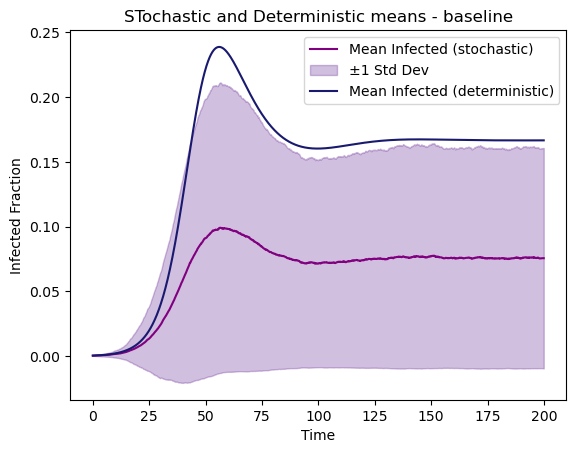

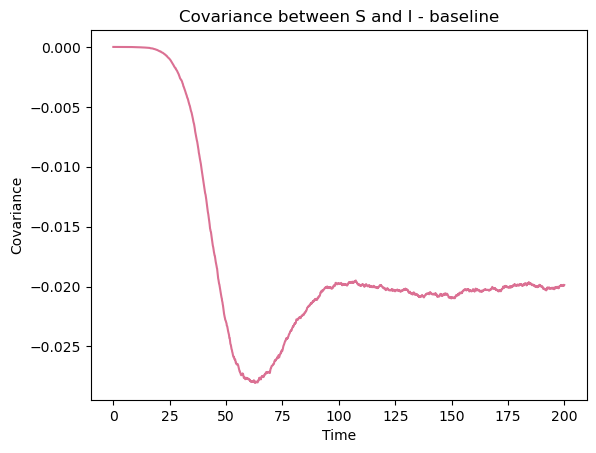

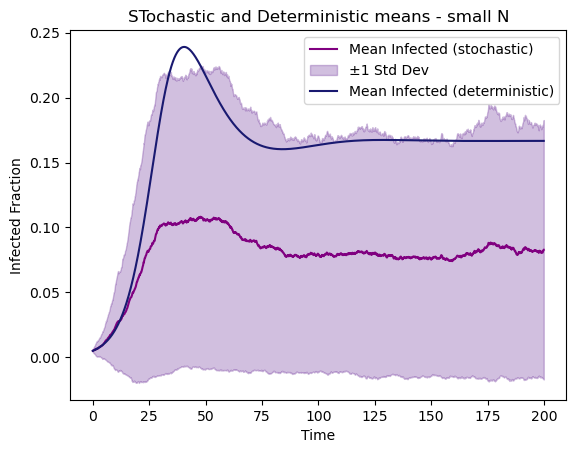

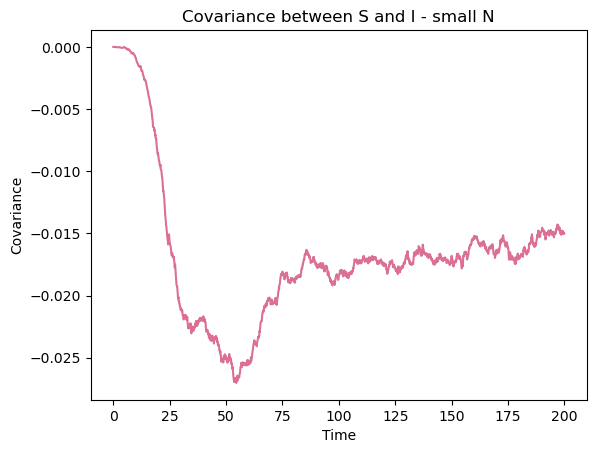

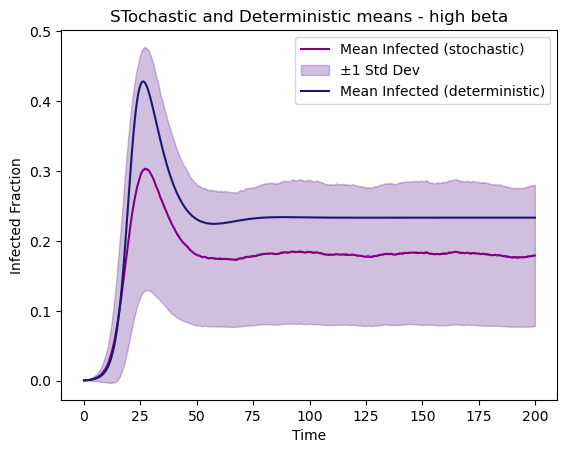

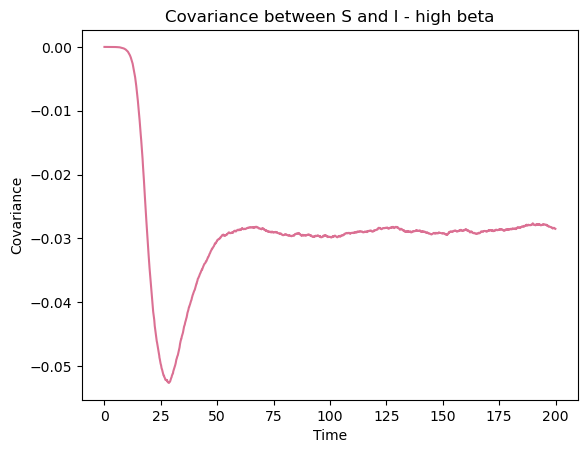

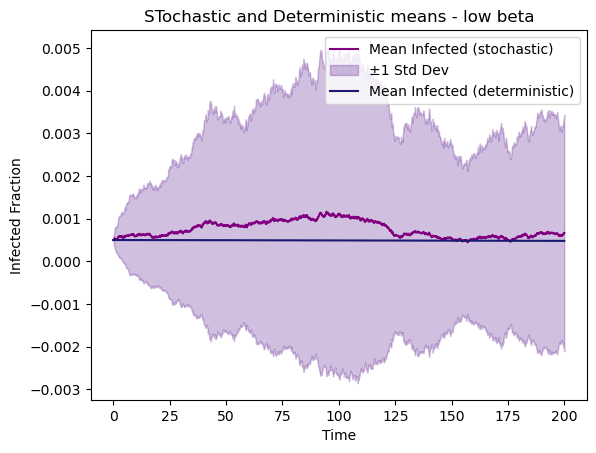

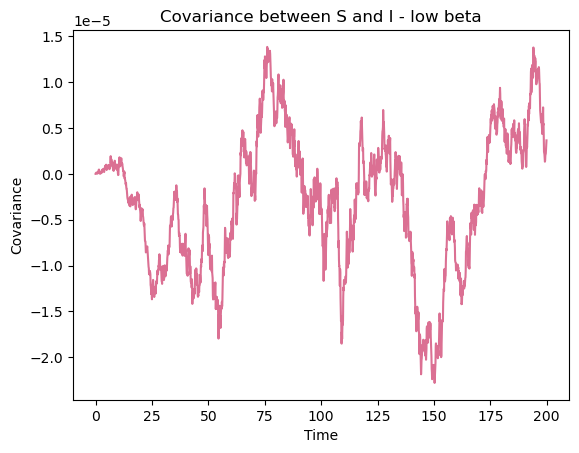

In [136]:
# Exercise 1.2

# Common time grid for comparaisons:
def nice_grid(times, sir, t_grid):
    times = np.array(times)
    vals = np.array(sir)
    index = np.searchsorted(times, t_grid, side='right') - 1 # get value at or before
    index = np.clip(index, 0, len(vals) - 1) 
    return vals[index]

# Get data over multiple runs
def ensemble(n_sims, t, dt, N, beta, gamma, mu):
    t_grid = np.arange(0, t, dt)
    S_ens = np.zeros((n_sims, len(t_grid)))
    I_ens = np.zeros((n_sims, len(t_grid)))
    R_ens = np.zeros((n_sims, len(t_grid)))
    for i in range(n_sims):
        S0, I0, R0 = N - 1, 1, 0
        times, S, I, R = gillespies_sir(t, S0, I0, R0, beta, gamma, mu)
        S_ens[i, :] = (nice_grid(times, np.array(S) / N, t_grid))
        I_ens[i, :] = (nice_grid(times, np.array(I) / N, t_grid))
        R_ens[i, :] = (nice_grid(times, np.array(R) / N, t_grid))
    return t_grid, S_ens, I_ens, R_ens

# Simulation variabiiity
def get_stats(n_sims, t, dt, N, beta, gamma, mu):
    t_grid, S_ens, I_ens, R_ens = ensemble(n_sims, t, dt, N, beta, gamma, mu)

    S_mean = np.mean(S_ens, axis=0)
    I_mean = np.mean(I_ens, axis=0)
    R_mean = np.mean(R_ens, axis=0)
    # std not pure variance, easier to interpret
    S_std = np.std(S_ens, axis=0)
    I_std = np.std(I_ens, axis=0)
    R_std = np.std(R_ens, axis=0)

    cov = ((S_ens - S_mean) * (I_ens - I_mean)).mean(axis=0)

    # get deterministic sir to compare
    S_det, I_det, R_det = integrate_det_sir([N - 1, 1, 0], t_grid, beta, gamma, mu)
    S_det, I_det, R_det = S_det / N, I_det / N, R_det / N # normalise again

    return {'t': t_grid, 
            'S_mean': S_mean, 'I_mean': I_mean, 'R_mean': R_mean,
            'S_std': S_std, 'I_std': I_std, 'R_std': R_std,
            'cov': cov,
            'S_det': S_det, 'I_det': I_det, 'R_det': R_det}
   
# Plot
def plot_stats(stats, title='STochastic and Deterministic means'):
    t = stats['t']
    I_mean, I_std, I_det = stats['I_mean'], stats['I_std'], stats['I_det']

    plt.figure()
    plt.plot(t, I_mean, color='purple', label='Mean Infected (stochastic)')
    plt.fill_between(t, I_mean - I_std, I_mean + I_std, color='indigo', alpha=0.25, label='±1 Std Dev')
    plt.plot(t, I_det, color='midnightblue', label='Mean Infected (deterministic)')
    plt.xlabel('Time')
    plt.ylabel('Infected Fraction')
    plt.legend()
    plt.title(title)
    plt.show()

def plot_cov(stats, title='Covariance between S and I'):
    t = stats['t']
    cov = stats['cov']
    plt.figure()
    plt.plot(t, cov, color='palevioletred')
    plt.xlabel('Time')
    plt.ylabel('Covariance')
    plt.title(title)
    plt.show()

params = [
    {'type': 'baseline', "N": 2000, "beta": 0.3, "gamma": 0.1, "mu": 0.05},
    {'type': 'small N', "N": 200, "beta": 0.3, "gamma": 0.1, "mu": 0.05},
    {'type': 'high beta', "N": 2000, "beta": 0.5, "gamma": 0.1, "mu": 0.05},
    {'type': 'low beta', "N": 2000, "beta": 0.15, "gamma": 0.1, "mu": 0.05}
]

for p in params:
    stats = get_stats(n_sims=100, t=200, dt=0.1, N=p['N'], beta=p['beta'], gamma=p['gamma'], mu=p['mu'])
    plot_stats(stats, title=f'STochastic and Deterministic means - {p["type"]}')
    plot_cov(stats, title=f'Covariance between S and I - {p["type"]}')